In [7]:
from GaussianCopulaImp.gaussian_copula import GaussianCopula
from GaussianCopulaImp.low_rank_gaussian_copula import LowRankGaussianCopula
from GaussianCopulaImp.helper_data_generation import load_GSS, load_movielens1m_top150
from GaussianCopulaImp.helper_evaluation import get_smae, get_mae
from GaussianCopulaImp.helper_mask import mask_MCAR
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

Two versions of **GaussianCopulaImp** are available: one as a Python package available from PyPI, and the other as a R package (soon available from CRAN). Both versions use the same algorithms and have the same functionality. Here we use the Python version to demonstrate how to use **GaussianCopulaImp** correctly and properly.

## Quick start

As a quick start illustration, we first use nine demographic variables from the 2014 General Social Survey data: age (`AGE`), highest degree (`DEGREE`), income (`RINCOME`), subjective class identification (`CLASS_`), satisfication with the work (`SATJOB`), weeks worked last year (`WEEKSWRK`), general happiness (`HAPPY`), condition of health (`HEALTH`), and frequency of spending evening at bar (`SOCBAR`). All variables are ordinal variables encoded as integers, although with varying number of ordinal categories. The ordinal categories could be exact numbers such as $0, 1, \cdots, 52$ for `WEEKSWRK`. It could also be ordered categories, for example 1, 2, 3 for the question "how would you say things are these days" (`HAPPY`) correspond to "Very happy", "Pretty happy", "Not too happy".  This dataset comes with many missing values due to anwsers like "Don't know", "No answer", "Not applicable", etc.

The dataset has 2538 rows


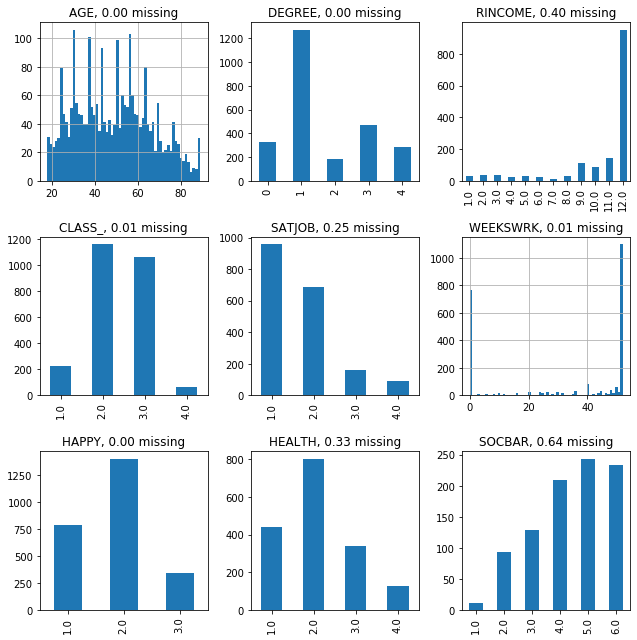

In [33]:
cols = ['AGE', 'DEGREE', 'RINCOME', 'CLASS_', 'SATJOB', 'WEEKSWRK', 'HAPPY', 'HEALTH', 'SOCBAR']
data_gss = load_GSS(cols = cols)
print(f'The dataset has {len(data_gss)} rows')
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for i,col in enumerate(data_gss):
    if col in ['AGE', 'WEEKSWRK']:
        data_gss[col].dropna().hist(ax=axes[i//3, i%3], bins=60)
    else:
        data_gss[col].dropna().value_counts().sort_index().plot(kind='bar', ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{col}, {data_gss[col].isna().mean():.2f} missing')
plt.tight_layout()

We further create $10\%$ missing entries for methods evaluation by randomly samping the observed entries without replacement. 

In [12]:
data_gss_masked = mask_MCAR(X=data_gss.to_numpy(), mask_fraction=0.1, seed=101)

The Python package has an API consistent with the `sklearn.impute` module. To impute the missing entries in an incomplete dataset, we simply create a model instance and call `fit_transform(X)` with the default setting. The default choice uses `training_mode='standard'`, which corresponds to the standard EM algorithm in [Our KDD]. 

In [7]:
model = GaussianCopula()
t1 = time.time()
Ximp = model.fit_transform(X=data_gss_masked)
t2 = time.time()
print(f'Runtime: {t2-t1:.2f} seconds')

Runtime: 50.86 seconds


Note variables in GSS dataset have different scales. If we do not want the imputation evaluation to be dominated by a single variable with large scale, we can use the scaled mean abosulte error (SMAE), the imputation MAE of a method scaled by the imputation MAE of the median imputation, for each variable and then use its average as the overall evaluation error. As shown below, the Gaussian copula imputation improves over median imputaiton by $13\%$.

In [48]:
smae = get_smae(x_imp=Ximp, x_true=np.array(data_gss), x_obs=data_gss_masked)
smae.mean()

0.8659812814554466

We can also extract the copula correlation estimate to see which variables are correlated. Those estimated correlation may be seen as the a rank-based correlation like kendall's tau correlation.

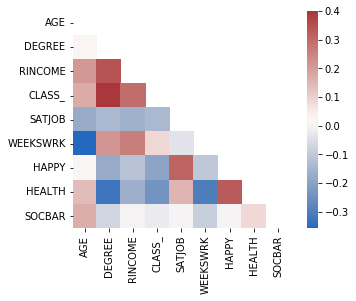

In [18]:
copula_corr_est = model.get_params()['copula_corr']
mask = np.zeros_like(copula_corr_est)
mask[np.triu_indices_from(mask)] = True
_ = sns.heatmap(copula_corr_est, 
                xticklabels=names, yticklabels=names, 
                vmax=0.4, mask=mask, square=True, cmap='vlag')

### Determine the variable types

When fitting the Gaussian copula model in executing `fit_transform()`, the model needs to know which variables are continuous and which are ordinal. We did not specify data types in the previous call because the model can use the default setting to automatically make the decision. We could find out which variables are treated as continuous vairables during fitting, by accessing the attribute `cont_indices`. As shown below, the default setting treats only `AGE` as a continuous variable.

In [19]:
print(names[model.cont_indices].to_list())

['AGE']


Correctly specifying the variable types is very important because the model can fail to converge if a variable having large multiplicity of some value is set as a continuous variable. That is because the Gaussian copula model assumes that the data has joint normal distribution after some monotonic transformation. However, the transformation does not change the multiplicity. Thus no matter what transformation supplied, the joint normal distribution assumption is seriously violated in the data with large multiplicity. Such problem has also been observed in [Cite Peter Hoff]. If we have domain knowledge on the variable types, we can directly tell the model the continuous varibles' location by `model.fit_transform(cont_indices = cont_indices)` with an array-like variable `cont_indices` containing all continuous variables indices. 

If we do not have such prior knowledge, the default setting is a good approach to go with. It tries to guess the variable type based on the mode occurrence ratio: a variable is categorized as ordinal if and only if its mode occurrence ratio is above the minimal allowed value `min_ord_ratio=10%`. This criterion is created to prevent a variable with high multiplicity from being treated as continuous. For example, all variables with no more than 10 ordinal levels will be treated as ordinal. For those variables with more than 10 ordinal levels, the model only treats them as ordinal if the distribution is significantly spiked at some level. We can also change the threshold when creating a model `GaussianCopula(min_ord_ratio=0.1)`, if needed. More concretely, let us look into the mode occurence ratio across variables.

In [20]:
data_gss.apply(lambda x: x.dropna().value_counts(normalize=True).max())

AGE         0.023725
DEGREE      0.500000
RINCOME     0.624425
CLASS_      0.460500
SATJOB      0.504485
WEEKSWRK    0.436530
HAPPY       0.554545
HEALTH      0.469006
SOCBAR      0.264706
dtype: float64

Now it is clear why only `AGE` is treated as continuous. While `WEEKSWRK` has many ordinal categories, it is mostly appearing in two cateories: 0 and 52, and thus has large mode occurence frequency $0.44$. In contrast, the probability mass of `AGE` is more spreaded out and thus it has a much smaller mode occurence frequency $0.02$. But what happens if we insist on setting `WEEKWRK` as an ordinal variable? We will see that would cause the algorithm to diverge, after introducing how to diagnose the model convergence in next section.

**YX notes**
1.  Perhaps interesting to find an example where a variable could be treated either as continuous or ordinal
2.  Maybe say something about the speed: all continuous is much faster than all ordinal

### Stopping criterion

The package tracks the model parameters change as the stopping criterion. Specifically, the algorithm stops when $\frac{||\Sigma_{t+1}-\Sigma_{t}||_F}{||\Sigma_{t}||_F}$ is below the specified `tol`, where $\Sigma_t$ is the model parameter estiamte at the $t$-th iteration. The default value  $0.001$ works well in most cases. The default maximal iterations, `max_iter`, is set as $50$. In practice, the algorithm converges in less than 30 iteraitons for most cases.

Recall the actual objective value is the marginal likelihood at the observed locations, averaged over all instances. When all variables are continuous, the marginal distribution is actually multivariate Gaussian and thus easy to compute. The actual objective value can then be tracked to better monitor the algorithm's performance. However, when there exists ordinal variables, the mariginal distribution is very hard to compute. Still, the package provides an approximated likelihood value by treating the ordinal variables as continuous. Note the special treatment is not applied to and thus will not hurt the actual algorithm fitting. In most cases and even those where all variables are ordinal, the computed likelihood values are found to be good approximation: it monotonically incraeses during the fitting process and finally converges. The computed likelihood also provides an early stopping criterion: the algorithm will stop if the likelihood values fail to increase by a certain amount (default is $1\%$). Such early stopping criterion is found to be effective against overfitting sometimes. Now let us see its effect on the GSS dataset. To cancel the early stopping criterion, we can simply set the minimal required likelihood increase ratio, `likelihood_min_increase`, to zero. We can also monitor the parameter update ratio and the likelihood value during fitting, by setting `verbose=1` when creating the model.

**YX notes**
1.  Need to discuss the early stopping criterion. Values, 1st order difference, 2nd order difference of the objective?
2.  We did not include the normalization constant term in the likelihood evaluation

In [21]:
t1 = time.time()
model_longer = GaussianCopula(likelihood_min_increase=0, verbose=1)
Ximp_longer = model_longer.fit_transform(X=data_gss_masked)
t2 = time.time()
print(f'Runtime: {t2-t1:.2f} seconds')

Iteration 1: copula correlation update ratio 0.1150, likelihood -2.4993
Iteration 2: copula correlation update ratio 0.0624, likelihood -2.3916
Iteration 3: copula correlation update ratio 0.0354, likelihood -2.3316
Iteration 4: copula correlation update ratio 0.0215, likelihood -2.2977
Iteration 5: copula correlation update ratio 0.0140, likelihood -2.2779
Iteration 6: copula correlation update ratio 0.0096, likelihood -2.2657
Iteration 7: copula correlation update ratio 0.0068, likelihood -2.2580
Iteration 8: copula correlation update ratio 0.0050, likelihood -2.2530
Iteration 9: copula correlation update ratio 0.0038, likelihood -2.2496
Iteration 10: copula correlation update ratio 0.0029, likelihood -2.2472
Iteration 11: copula correlation update ratio 0.0022, likelihood -2.2456
Iteration 12: copula correlation update ratio 0.0018, likelihood -2.2444
Iteration 13: copula correlation update ratio 0.0014, likelihood -2.2436
Iteration 14: copula correlation update ratio 0.0011, likeli

We can access the number of iteratios of the previous model run by accessing attribute `n_iter_`. As shown beloe, the algorithm takes 8 more iterations to achieve convergence, after canceling the early stopping criterion. 

In [22]:
print(f'Converged in {model.n_iter_} with early stopping, but {model_longer.n_iter_} without early stopping')

Converged in 5 with early stopping, but 15 without early stopping


The likelihood values keep climbing at a slow rate (below $1\%$), as shown below.

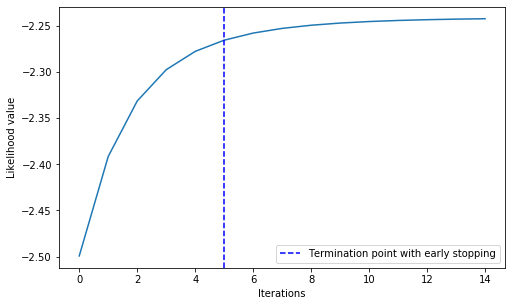

In [30]:
fig, ax = plt.subplots(figsize = (8, 4.8))
ax.plot(model_longer.likelihood)
ax.set_ylabel('Likelihood value')
ax.set_xlabel('Iterations')
ax.axvline(x=model.n_iter_, label='Termination point with early stopping', color='b', linestyle='--')
_ = ax.legend()

Now we compute the imputation error of the model trained without early stopping. As shown below, its imputation error improves over the model trained with early stopping by small amount, at the cost of triple computation time.

In [31]:
smae_longer = get_smae(x_imp=Ximp_longer, x_true=np.array(data_gss), x_obs=data_gss_masked)
smae_longer.mean()

0.8616668129544429

It is observed that canceling the early stop criterion may achieve slight improvement, but may also cause overfitting. Moreover, the convergence in late stage is slow and it often takes more than twice long to finish. Thus whether to use the early stopping criterion should depend on the task. If we just want a pretty good estimator in short time, the default choice `tol=0.001, likelihood_min_increase=0.01` is good to go. If we want to have an estimator that fits the data as well as possible, we could decrease either `tol` (smaller positive) or `likelihood_min_increase` (as low as 0). The particular choice can be tuned using a validation set, but in general the results from the default setting will be close to that from a carefully tuned setting. 

### Model divergence diagnosis: an example of improper data types specification

Recall previously we found the variable `WEEKSWRK` has large mode occurence ratio and thus is treated as an ordinal variable. desptie it has many ordinal levels. Now let us see what happens if we change its data type to continuous. Wo do so by manually provide `cont_indices` when calling `fit_transform`.

In [32]:
m_gss_v2 = GaussianCopula(verbose=1, max_iter=10)
Ximp_gss_v2 = m_gss_v2.fit_transform(data_gss_masked, cont_indices = [0, 5])
print(f'Continuous variables: {names[m_gss_v2.cont_indices].to_list()}')

Iteration 1: copula correlation update ratio 0.1211, likelihood -4.4555
Iteration 2: copula correlation update ratio 0.0746, likelihood -4.4709
Iteration 3: copula correlation update ratio 0.0507, likelihood -4.5202
Iteration 4: copula correlation update ratio 0.0376, likelihood -4.5961
Iteration 5: copula correlation update ratio 0.0301, likelihood -4.6886
Iteration 6: copula correlation update ratio 0.0267, likelihood -4.7852
Iteration 7: copula correlation update ratio 0.0279, likelihood -4.8766
Iteration 8: copula correlation update ratio 0.0327, likelihood -4.9613
Iteration 9: copula correlation update ratio 0.0390, likelihood -5.0450
Iteration 10: copula correlation update ratio 0.0430, likelihood -5.1388
Convergence not achieved at maximum iterations
Continuous variables: ['AGE', 'WEEKSWRK']


In [33]:
smae_v2 = get_smae(x_imp=Ximp_gss_v2, x_true=data_gss.to_numpy(), x_obs=data_gss_masked)
smae_v2.mean()

0.9432039977394461

We stopped the algorithm after 10 iterations since it already started to diverge. The result is quite surprising that changing a single variable's type can make the whole algorithm diverge. The resulting imputation error also largely increases. It is a strong notice that we need to specify data types properly. Luckily, the default setting works well in most cases experimented. Another thing we can learn here is that the computed likelihood indicates how well the Gaussian copula model fits the data. If we see that the likelihood values do not monotonically increase during the fitting, it is a signal that the model does not fit the data well. That could happen even when the algorithm actually converges. Let us see such an example on the GSS dataset excluding the variable `SOCBAR`.

In [45]:
data_gss_masked_partial = data_gss_masked[:,:6]
print(f'Used variables: {names[:6].to_list()}')

m_gss_v3 = GaussianCopula(verbose=1)
Ximp_gss_v3 = m_gss_v3.fit_transform(data_gss_masked_partial, cont_indices = [0, 5])
print(f'Continuous variables: {names[:6][m_gss_v3.cont_indices].to_list()}')

Iteration 1: copula correlation update ratio 0.1113, likelihood -3.7861
Iteration 2: copula correlation update ratio 0.0714, likelihood -3.8238
Iteration 3: copula correlation update ratio 0.0481, likelihood -3.8755
Iteration 4: copula correlation update ratio 0.0335, likelihood -3.9387
Iteration 5: copula correlation update ratio 0.0235, likelihood -4.0070
Iteration 6: copula correlation update ratio 0.0162, likelihood -4.0707
Iteration 7: copula correlation update ratio 0.0111, likelihood -4.1222
Iteration 8: copula correlation update ratio 0.0075, likelihood -4.1593
Iteration 9: copula correlation update ratio 0.0051, likelihood -4.1837
Iteration 10: copula correlation update ratio 0.0035, likelihood -4.1989
Iteration 11: copula correlation update ratio 0.0025, likelihood -4.2079
Iteration 12: copula correlation update ratio 0.0018, likelihood -4.2131
Iteration 13: copula correlation update ratio 0.0013, likelihood -4.2159
Iteration 14: copula correlation update ratio 0.0010, likeli

Now we see while the model converges, the likelihood values do not increase during the whole fitting. To know how well the model imputes, we also run the default model and compare their imputation performance.

In [67]:
m_subset = GaussianCopula(verbose=1)
Ximp_gss_subset = m_subset.fit_transform(data_gss_masked_partial)
print(f'Continuous variables: {names[:6][m_subset.cont_indices].to_list()}')

smae_d = get_smae(x_imp=Ximp_gss_subset, x_true=data_gss.to_numpy()[:,:6], x_obs=data_gss_masked_partial)
print(f'Imputation error of default run: {smae_d[:6].mean():.4f}')
smae_mis = get_smae(x_imp=Ximp_gss_v3, x_true=data_gss.to_numpy()[:,:6], x_obs=data_gss_masked_partial)
print(f'Imputation error of current run: {smae_mis.mean():.4f}')

Iteration 1: copula correlation update ratio 0.1013, likelihood -1.8411
Iteration 2: copula correlation update ratio 0.0545, likelihood -1.7708
Iteration 3: copula correlation update ratio 0.0320, likelihood -1.7329
Iteration 4: copula correlation update ratio 0.0200, likelihood -1.7115
Iteration 5: copula correlation update ratio 0.0132, likelihood -1.6990
early stop because the likelihood increase is below 0.01
Convergence achieved at iteration 5
Continuous variables: ['AGE']
Imputation error of default run: 0.8563
Imputation error of current run: 0.9106


Again, we see the improperly specified data types largely hurt the imputation performance, even when the algorithm converges with improperly specified data types.

## Acceleration through parallelism, minibatch training, and low rank structure

Running `GaussianCopula()` with the default setting (`training_mode='standard'`) has computational complexity $O(np^3)$ for each EM iteration. However, we can achieve great amount of acceleration if using it cleverly. 
To speed up the model's execution, three tools are provided: parallelism, minibatch training and low rank structure.

Parallelism is the most straightforward and the easiest acceleration tool to use. By calling `GaussianCopula(n_jobs=m)`, we can distribute the computation across $n$ rows using $m$ cores. It is best suited for datasets with large $n$ and small $p$. 

Minibatch training, invoking by calling `GaussianCopula(training_mode='minibatch-offline')`, also aims to accelerate the model's exceution for large $n$ and small $p$ problem. It randomly shuffles the data and divide them into minibatches, and then perform model updates at each minibatch. The algorithm converges much faster as the model is updated more frequently. It can also be used together with parallelism to distribute the computation across rows inside a minibatch, by calling `GaussianCopula(training_mode='minibatch-offline', n_jobs=m)`. Although it requires additional work to choose the learning rates, batch size and a different stopping criterion, we will see the selection is quite simple shortly.

Low rank structure is developed for large $p$ problem ($p\geq 1000$) where the $O(np^3)$ computation is unaffordable. The model created by calling `LowRankGaussianCopula(rank=k)` has $O(npk^2)$ complexity per iteration, making it efficient to run even $p$ is at the scale of thousands. It also supports parallelism by specifying `n_jobs`, and the computation is distributed over all rows and all columns. Unfortunately, the minibatch training for `LowRankGaussianCopula()` is nontrivial and has not yet been developed. Still, if working with large $n$ and large $p$ dataset, using `LowRankGaussianCopula(rank=k, n_jobs=m)` with parallelism should be satisfying.

For the following, we will see guidelines and examples on how to use minibatch training and low rank Gaussian copula properly.

### Acceleration for large $n$ problem: minibatch training

Recall at each EM iteration for minibatch training, the update rule is $\Sigma_{t+1}=(1-\eta_{t+1})\Sigma_t+\eta_{t+1}\hat\Sigma$, where $\Sigma_t$ is the model estiamte at iteration $t$, $\hat \Sigma$ is the new estiamte on the used minibatch and $\eta_t$ is the step size. Thus to use minibatch training, we need to specify the decaying step size $\{\eta_t\}$. Also, we need to determine on the minibatch size $s$ and the number of iterations $k$ to run. 

According to [online EM and our online], the decayling step size should satisfy $\sum_{t=1}^\infty \eta_t=\infty$ and $\sum_{t=1}^\infty \eta_t^2<\infty$. To conveniently ensure $\eta_t \in (0, 1)$ for all $t$, it is recommended to use $\eta_t = c/(c+t)$ with $c>0$. Roughly speaking, the model receives $50\%$ udpate at $c$-th iteration and $5\%$ update at $19c$-th iteration, when $c$ is an integer. It is often sufficient to tune $c$ in the range $(0, 10)$, and $c=5$ works well in many settings experimented. 

On the selection of batch size $s$, the update rule [quote equation] requires $s\geq p$ to avoid singular matrix operation [our online]. Still, it is observed that even if this requirement is slightly violated (not too small $s$), the algorithm continues to run smoothly. For the purpose to accelerate the algorithm, it should be easy to satisfy $s\geq p$, since if $p$ is too large, we should use `LowRankGaussianCopula()` instead. 

The selection of maximum number of iterations matters more now, because the stochastic fluctuation over minibatches makes it hard to decide convergence based on the parameter update ratio or the likelihood increase. Thus this package disables the early stopping criterion based on the likelihodd increase for minibatch traing. While the algorithm still converges when the parameter update ratio goes below `tol`, that mostly happens when $\eta_t$ gets close to $0$ when $t$ is large enough. Instead of specifying an exact maxmium number of iterations, it may be more convenienet to select it based on the number of passes desired, i.e. $n_{\textit{iter}}=\left \lceil{\frac{n}{s}}\right \rceil  \times n_{\textit{pass}}$, where $s$ is the selected minibatch size. Often using $n_{\textit{pass}}=2$ (the default setting) or $3$ gives good enough results.

To use the default setting of step size $\eta_t=5/(t+5)$, minibatch size $s=100$ and the maximum number of iterations $n_{\textit{iter}}=\left \lceil{\frac{n}{s}}\right \rceil  \times 2$, simple run the following:

In [20]:
model_minibatch = GaussianCopula(training_mode='minibatch-offline')
t1=time.time()
Ximp_minibatch = model_minibatch.fit_transform(X=data_gss_masked)
t2=time.time()
print(f'Runtime: {t2-t1:.2f} seconds')
smae_batch_2pass = get_smae(x_imp=Ximp_minibatch, x_true=data_gss.to_numpy(), x_obs=data_gss_masked)
print(f'Imputation error: {smae_batch_2pass.mean():4f}')

Runtime: 19.46 seconds
Imputation error: 0.849737


Interestingly, the imputation from minibatch training not only reduces the runtime from $50$s to $19$s but also reduces the imputation error from $0.8660$ to $0.8497$! Here we used a relative small dataset for illustration purpose. The acceleration will be more significant (as large as $85\%$ time reduction) on larger datasets [cite our online].

We could also supply their own choice of step size, minibatch size and the maximum number of iterations by changing either `num_pass` or `max_iter`.  When `num_pass` is set as an integer, the parameter `max_iter` will not be used. To directly specify `max_iter`, set `num_pass` as `None`. Let us run the minibatch algorithm with three passes by specifying `max_iter`.

In [25]:
max_iter=np.ceil(data_gss_masked.shape[0]/100*3).astype(np.int32)
model_minibatch_3pass = GaussianCopula(training_mode='minibatch-offline', 
                                       stepsize_func = lambda t, c=5:c/(c+t),
                                       batch_size = 100,
                                       num_pass = None, 
                                       max_iter = max_iter
                                      )
t1=time.time()
Ximp_minibatch_3pass = model_minibatch_3pass.fit_transform(X=data_gss_masked)
t2=time.time()
print(f'Runtime: {t2-t1:.2f} seconds')
print(f'Maximal iterations allowed: {max_iter}. Actual run iterations: {model_minibatch_3pass.n_iter_}')
smae_batch_3pass = get_smae(x_imp=Ximp_minibatch_3pass, x_true=data_gss.to_numpy(), x_obs=data_gss_masked)
print(f'Imputation error: {smae_batch_3pass.mean():.4f}')

Runtime: 29.83 seconds
Maximal iterations allowed: 77. Actual run iterations: 77
Imputation error: 0.853659


The results show one more pass slightly hurts the imputation performace. Let us also see the performance of only one pass.

In [26]:
model_minibatch_1pass = GaussianCopula(training_mode='minibatch-offline', 
                                       stepsize_func = lambda t, c=5:c/(c+t),
                                       batch_size = 100,
                                       num_pass = 1
                                      )
t1=time.time()
Ximp_minibatch_1pass = model_minibatch_1pass.fit_transform(X=data_gss_masked)
t2=time.time()
print(f'Runtime: {t2-t1:.2f} seconds')
smae_batch_1pass = get_smae(x_imp=Ximp_minibatch_1pass, x_true=data_gss.to_numpy(), x_obs=data_gss_masked)
print(f'Imputation error: {smae_batch_1pass.mean():.4f}')

Runtime: 11.55 seconds
Imputation error: 0.863013


It looks like $2$ passes is our best option on this GSS dataset! In general, the number of passes to take should be a parameter to be tuned using a validation set. 

### Acceleration for large $p$ problem: low rank structure

Recall the low rank structure refers to that the actual observed $p$-dimensional data is generated by transforming and corrupting a latent $k$-dimensional variable, and the copula correlation matrix has the decomposition $\Sigma = WW^\top +\sigma^2 \mathrm{I}_p$ with $W\in \mathbb{R}^{p\times k}$ and $\sigma^2\in (0,1)$. We need to tune the rank $k$ to have the best possible result using the low rank Gaussian copula model. In practice, it is found the optimal rank is often below $20$, even when there are around $2500$ variabels [cite LRGC paper]. Besides of the imputed dataset, the fitted model also return estimates of $W$ and $s\sigma^2$. The estimated $\sigma^2$ tells us how much the model explains the data. It stands for the variance proportion of the noise: $0$ means no noise and thus the model perfectly explains the data, while $1$ means completely noise and the model cannot explain the data at all.

To show the speedup of the low rank Gaussian copula model, we use a subset of the MovieLens1M dataset. More specificly, we select $150$ movies with most ratings and users who rates at least $50$ movies among them. That yields a dataset of size $1858\times 150$ with observation ratio $46.2\%$. The dataset is selected to have a moderate large $p$, so that it does not take too long to run `GaussianCopula()` for runtime comparison. We further mask $10\%$ entries for evaluation. 

In [2]:
data_movie = load_movielens1m_top150()
n,p=data_movie.shape
mis_ratio=np.isnan(data_movie).mean()
print(f'{mis_ratio*100:.1f}% ratings are available from {n} users and {p} movies')
data_movie_masked = mask_MCAR(X=data_movie, mask_fraction=0.1, seed=101)

46.2% ratings are available from 1858 users and 150 movies


Now we run `GaussianCopula()` as well as `LowRankGaussianCopula()` with rank $10$. Here our goal is not to choose the optimal rank, but rather show the runtime comparison between two models. We also enable parallelism for both methods, using $4$ cores (mostly available on a laptop), for faster execution.

In [4]:
model_movie = GaussianCopula(verbose=1, n_jobs=4)
a = time.time()
Ximp_movie = model_movie.fit_transform(X=data_movie_masked)
b = time.time()
print(f'Full rank Gaussian copula run time: {(b-a)/60:.2} minutes')

Iteration 1: copula correlation update ratio 0.3730, likelihood -21.6560
Iteration 2: copula correlation update ratio 0.1530, likelihood -18.6946
Iteration 3: copula correlation update ratio 0.0687, likelihood -16.8478
Iteration 4: copula correlation update ratio 0.0373, likelihood -15.6435
Iteration 5: copula correlation update ratio 0.0234, likelihood -14.8081
Iteration 6: copula correlation update ratio 0.0161, likelihood -14.1949
Iteration 7: copula correlation update ratio 0.0119, likelihood -13.7241
Iteration 8: copula correlation update ratio 0.0093, likelihood -13.3501
Iteration 9: copula correlation update ratio 0.0075, likelihood -13.0448
Iteration 10: copula correlation update ratio 0.0062, likelihood -12.7907
Iteration 11: copula correlation update ratio 0.0052, likelihood -12.5756
Iteration 12: copula correlation update ratio 0.0045, likelihood -12.3912
Iteration 13: copula correlation update ratio 0.0039, likelihood -12.2315
Iteration 14: copula correlation update ratio 0

In [6]:
model_movie_lrgc = LowRankGaussianCopula(verbose=1, rank=10, n_jobs=4)
a = time.time()
Ximp_movie_lrgc = model_movie_lrgc.fit_transform(X=data_movie_masked)
b = time.time()
print(f'Low rank Gaussian copula run time: {(b-a)/60:.2} minutes')

Ater initialization, W has shape (150, 10) and sigma is 0.6598
Interation 1: noise ratio estimate 0.6334, copula parameter update ratio 0.1152, likelihood -20.8183
Interation 2: noise ratio estimate 0.6149, copula parameter update ratio 0.0532, likelihood -18.2274
Interation 3: noise ratio estimate 0.6110, copula parameter update ratio 0.0305, likelihood -17.8367
Interation 4: noise ratio estimate 0.6098, copula parameter update ratio 0.0218, likelihood -17.5798
Interation 5: noise ratio estimate 0.6097, copula parameter update ratio 0.0171, likelihood -17.5190
early stop because the likelihood increase is below 0.01
Convergence achieved at iteration 5
Low rank Gaussian copula run time: 3.1 minutes


Here are a few interesting facts. First, if we look at the per itertion time complexity, `GaussianCopula()` actually takes shorter time than `LowRankGaussianCopula()`, that is because the per iteration speedup of `LowRankGaussianCopula()` only exists when $p$ is large enough. Second, even though `GaussianCopula()` has smaller per iteration runtime, it takes 10 more iterations to converge. That is because `LowRankGaussianCopula()` has fewer parameters, i.e. stronger structure regularization. Thus even $p$ is not large enough to let `LowRankGaussianCopula()`  have per iteration speedup over `GaussianCopula()`, the low rank Gaussian copula model is still prefered for fast convergence. Third, since low rank Gaussian copula imposes additional strcture constraint and thus search parameters in a smaller space, its maximal likelihood should be smaller than that from the full rank Gaussian copula. That is verified here on the movielens1m dataset. At last, the estiamted noise ratio from `LowRankGaussianCopula()` is $0.61$, indicating small signal-to-noise ratio in the data. On such noisy data, overfitting can easily happen. Now let us see the imputation performance between two methods. Since all entries are now in the scale of 1-5, we simply use MAE for evaluation.

In [28]:
mae_gc=get_mae(x_imp=Ximp_movie, x_true=data_movie, x_obs=data_movie_masked)
mae_lrgc=get_mae(x_imp=Ximp_movie_lrgc, x_true=data_movie, x_obs=data_movie_masked)
print(f'Imputation error: {mae_gc:.3f} for full rank Gaussian copula, {mae_lrgc:.3f} for low rank Gaussain copula')

Imputation error: 0.571 for full rank Gaussian copula, 0.565 for low rank Gaussain copula


The results agree with our intuition: compared to the low rank model, the full rank model has slightly large imputation error, which indiates overfitting. That provides us another guideline on the model selection: `LowRankGaussianCopula()` with small rank should be prefered when there is small signal-to-noise ratio.

## Imputation confidence intervals

## Multiple imputation

## Online tasks